# Script to prepare data for YOLO training

In [21]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display

In [22]:
# Get csv paths
path_csv_train = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Audible/train_audible_recording_chunks.csv"
path_csv_test = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Audible/test_audible_recording_chunks.csv"
path_csv_val = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Audible/val_audible_recording_chunks.csv"

# Get spectrograms paths
path_spectro_train = "../../Dataset acoustique insectes/Sélection morceaux audio 5s/Audible/train_spectro"
path_spectro_test = "../../Dataset acoustique insectes/Sélection morceaux audio 5s/Audible/test_spectro"
path_spectro_val = "../../Dataset acoustique insectes/Sélection morceaux audio 5s/Audible/val_spectro"

# Using pandas to read the CSV file into a DataFrame
df_train = pd.read_csv(path_csv_train)
df_test = pd.read_csv(path_csv_test)
df_val = pd.read_csv(path_csv_val)

In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])

def get_data_info(df):
    y = df['label']
    y_category = df['label_category']
    y_kingdom = df['label_kingdom']
    y_class = df['label_class']
    y_order = df['label_order']
    y_family = df['label_family']
    y_subfamily = df['label_subfamily']

    # Convertir les étiquettes en nombres
    y_encoded = label_encoder.transform(y)
    
    # create new empty dataframe
    new_df = pd.DataFrame()

    new_df['label'] = y_encoded
    new_df['t1'] = df["annotation_initial_time"] - df["chunk_initial_time"]
    new_df['t2'] = df["annotation_final_time"] - df["chunk_initial_time"]
    new_df['f1'] = df['min_frequency'].astype(int)
    new_df['f2'] = df['max_frequency'].astype(int)
    code_unique = df['code_unique'] 
    str_to_add = '_split_' + df['chunk_initial_time'].astype(str) + '_' + df['chunk_final_time'].astype(str)
    new_df['filename'] = code_unique + str_to_add + '.png'
    new_df['sr'] = df['sampling_rate']
    new_df['duration_chunk'] = df['chunk_final_time'] - df['chunk_initial_time']

    # Gestion des valeurs manquantes
    new_df = new_df.dropna()

    return new_df

info_train = get_data_info(df_train)
info_test = get_data_info(df_test)
info_val = get_data_info(df_val)

In [24]:
info_train

,label,t1,t2,f1,f2,filename,sr,duration_chunk
0,65,0.355751,4.147038,0,375,Anura_XXXXigeXXES_01VII2022_330_split_0_5.png,44100,5
1,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_0_5.png,44100,5
2,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_5_10.png,44100,5
3,65,0.346426,1.708443,0,375,Anura_XXXXigeXXES_01VII2022_330_split_5_10.png,44100,5
4,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_10_15.png,44100,5
...,...,...,...,...,...,...,...,...
10784,9,2.296621,3.300916,5007,16160,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5
10785,9,4.691478,5.000000,4750,16553,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5
10786,9,0.000000,0.674299,5416,17367,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5
10787,9,3.399642,3.863163,5007,15776,Aves_KrDe_AwSw00PL_16VII2014_4613_split_180_18...,44100,5


t1: 0.0 t2: 5.0 f1: 3248 f2: 4453
t1_pixel: 0 t2_pixel: 431 f1_pixel: 875 f2_pixel: 819


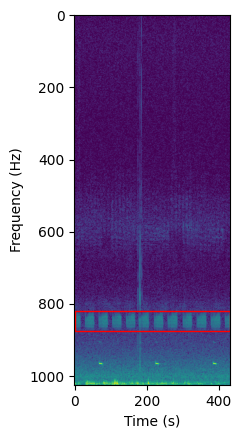

In [27]:
# plot spectrogram and bounding box for the first image

id = 1

# get the first image
img_path = os.path.join(path_spectro_train, info_train.iloc[id]['filename'])
img = Image.open(img_path)
draw = ImageDraw.Draw(img)

# Extract bounding box coordinates
t1 = info_train.iloc[id]['t1']
f1 = info_train.iloc[id]['f1']
t2 = info_train.iloc[id]['t2']
f2 = info_train.iloc[id]['f2']
print('t1:', t1, 't2:', t2, 'f1:', f1, 'f2:', f2)

# convert values to pixels
img_width, img_height = img.size
chunk_duration = info_train.iloc[id]['duration_chunk']

t1_pixel = int(t1 * img_width/chunk_duration)
t2_pixel = int(t2 * img_width/chunk_duration)

# for the frequency, the spectrogram is flipped
f1_pixel = img_height - int(f1 * img_height/(info_train.iloc[id]['sr']/2))
f2_pixel = img_height - int(f2 * img_height/(info_train.iloc[id]['sr']/2))

print('t1_pixel:', t1_pixel, 't2_pixel:', t2_pixel, 'f1_pixel:', f1_pixel, 'f2_pixel:', f2_pixel)

# Create a Rectangle patch
rect = plt.Rectangle((t1_pixel, f1_pixel), t2_pixel - t1_pixel, f2_pixel - f1_pixel, linewidth=1, edgecolor='r', facecolor='none')


# Set the axis labels
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.imshow(img)
plt.gca().add_patch(rect)